<a href="https://colab.research.google.com/github/ydeng-MLM/ECE687_Kaggle_Airbnb_Recommendation/blob/main/SVM__ECE687_Airbnb_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch was used for DNN built, but not enough optimization time 
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import nn

#Results analysis library
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

#Data preparation import
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#ML algorithms import
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

**Data preparation**

In [ ]:
#Reading the data from train.csv
df = pd.read_csv('train.csv')

In [ ]:
#Checking the columns
df.columns

Index(['id', 'Decision', 'Host_response_time', 'Host_is_superhost',
       'Host_has_profile_pic', 'Host_identity_verified', 'Neighbourhood',
       'Property_type', 'Room_type', 'Accommodates', 'Bathrooms_text',
       'Bedrooms', 'Beds', 'Essentials', 'Cooking', 'Balcony', 'Parking',
       'Price', 'Number_of_reviews', 'Review_scores_rating',
       'Instant_bookable', 'Month'],
      dtype='object')

In [ ]:
#Print out all the NaN entry
df.columns[df.isnull().any()].tolist()

['Host_response_time',
 'Host_is_superhost',
 'Host_has_profile_pic',
 'Host_identity_verified',
 'Bedrooms',
 'Beds',
 'Review_scores_rating']

In [ ]:
#Cleaning all the NaN entry
df['Host_response_time'].fillna("No response", inplace = True)
df['Host_is_superhost'].fillna("t", inplace = True)
df['Host_has_profile_pic'].fillna("t", inplace = True)
df['Host_identity_verified'].fillna("t", inplace = True)
df['Bedrooms'].fillna(1, inplace = True)
df['Beds'].fillna(1, inplace = True)
review_mean = df['Review_scores_rating'].mean()
df['Review_scores_rating'].fillna(review_mean, inplace = True)

df['Price'] = df['Price'].str.replace(',', '')
df['Price'] = df['Price'].str.replace('$', '')
df['Price'] = df['Price'].astype(float)


In [ ]:
#Use column transformer to define specific encoders for each column in the dataframe
column_trans = make_column_transformer((OneHotEncoder(drop='if_binary'),
                                        ['Host_is_superhost', 'Host_has_profile_pic', 'Host_identity_verified',
                                         'Instant_bookable']),
                                      (OrdinalEncoder(), ['Host_response_time', 'Neighbourhood', 'Property_type',
                                                          'Room_type', 'Bathrooms_text', 'Essentials', 
                                                          'Month']),
                                      remainder='passthrough')

In [ ]:
#Defining the label from the dataframe
labels = df.to_numpy()[:, 1].astype('float32')

#Encoder is defined here wth the column transformer
enc = column_trans.fit(df.drop(columns=['id', 'Decision']))
#Features now is encoded by the encoder
features = enc.transform(df.drop(columns=['id', 'Decision']))

#Defining the scaler and fit on the dataset
scaler = StandardScaler()
#scaler = RobustScaler()
scaler.fit(features)
#The features are now standarized by the standard scaler
features = scaler.transform(features)

**Train/Test set Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (6723, 20) (6723,)
Test (748, 20) (748,)


In [ ]:
kernel = ['linear', 'poly', 'rbf']
C = [1e-2, 1e-1, 1, 10, 100]
gamma = [1e-1, 1, 10]

# Create the random grid
random_grid = {'kernel': kernel,
               'C': C,
               'gamma': gamma}
print(random_grid)

{'kernel': ['linear', 'poly', 'rbf'], 'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.1, 1, 10]}


In [ ]:
#Random searching first to identify a good hyperparmeters range
clf = svm.SVC()
# Random search with 5 fold cross validation, 
clf_random = RandomizedSearchCV(estimator = clf, param_distributions=random_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
clf_random.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 45 is smaller than n_iter=100. Running 45 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


KeyboardInterrupt: ignored

In [ ]:
clf_random.best_params_

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {'kernel': ['rbf'],
               'C': [0.1, 1, 10],
               'gamma': [0.1, 1, 10]}
# Create a based model
clf = svm.SVC()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
clf = svm.SVC(kernel='rbf', C=10, gamma=0.1)
#10-fold KFold method for cross-validations 
cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean()

0.762157052642751

In [ ]:
time_arr = []
for i in range(10):
  start = time.time()
  clf.fit(X_train, y_train)
  end = time.time()
  time_arr.append(end - start)

print(np.mean(time_arr))

3.3430425405502318


Text(0, 0.5, 'Accuracy')

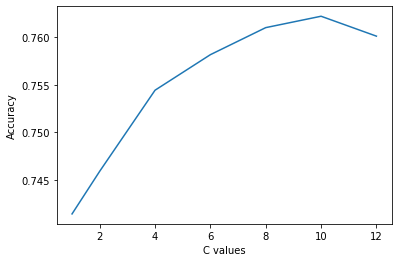

In [ ]:
accs = []

C_arr = [1, 2, 4, 6, 8, 10, 12]
for C in C_arr:
  clf = svm.SVC(kernel='rbf', C=C, gamma=0.1)
  acc = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean()
  accs.append(acc)


plt.plot(C_arr, accs)
plt.xlabel('C values')
plt.ylabel('Accuracy')

In [ ]:
clf.fit(X_train, y_train)

#Report final performance on test set
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))